In [2]:
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
door1 = pd.read_csv("data/data_door1.txt",  sep=";", header=None)
door1 = door1.set_axis(["Timestamp", "x", "y", "z", "pressure"], axis=1, inplace=False)

door2 = pd.read_csv("data/data_door2.txt",  sep=";", header=None)
# has 5 variables ???

testdata = pd.read_csv("data/testdata.csv", sep=";", header=None)
testdata = testdata.set_axis(["Timestamp", "x", "y", "z", "pressure"], axis=1, inplace=False)


In [4]:
door1.head()

,Timestamp,x,y,z,pressure
0,2975,-14.460515,0.517131,0.095765,83.465385
1,3015,-12.028084,0.421366,0.076612,83.465782
2,3055,-10.840598,0.344754,0.134071,83.465599
3,3095,-10.227702,0.344754,0.153224,83.465515
4,3134,-9.902101,0.325601,0.114918,83.465507


------------------------------------------------------------------------------

In [33]:
# FUNCTIONS

def plot_img(variable, show_range):
    if show_range == []: show_range = [0, len(timestamp)]
    plt.plot(timestamp[show_range[0]:show_range[1]], variable[show_range[0]:show_range[1]])
    
# [1, 2, 3, 4, 5 ...
# [0, 0, _, 0, 0]

#       [1, 2, 3, 4, 5 ...
# [0, 0, _, 0, 0]

# ... 95, 96, 97, 98, 99, 100]
#                   [0, 0, _, 0, 0]

def calculateMedian(variable, size):
    listOfMedians = list()
    for i in range(0, len(variable)):
        start = max(i - size//2, 0) # max to avoid negatives
        end = min(i + (size-size//2), len(variable)) # evitar problemes amb parells

        calculate_median = variable[start:end]
        calculate_median.sort()
        median = calculate_median[len(calculate_median)//2]
        listOfMedians.append(median)
    return listOfMedians

# too slow
def normalize(vector):
    return [float(i)/max(vector) for i in vector]

In [6]:
pressure = list(door1["pressure"])
x_axis = list(door1["x"])
y_axis = list(door1["y"])
z_axis = list(door1["z"])
timestamp = list(door1["Timestamp"])

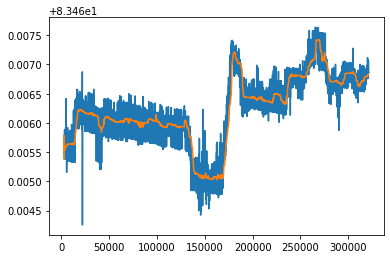

In [34]:
plot_img(pressure, [0, 8000])
pressureMedian = calculateMedian(pressure, 100)
plot_img(pressureMedian, [0, 8000])

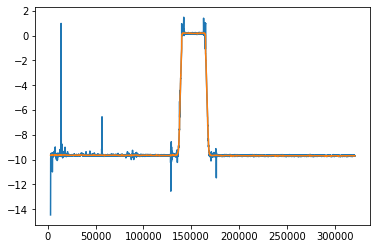

In [8]:
plot_img(x_axis, [0, 8000])
x_axisMedian = calculateMedian(x_axis, 100)
plot_img(x_axisMedian, [0, 8000])

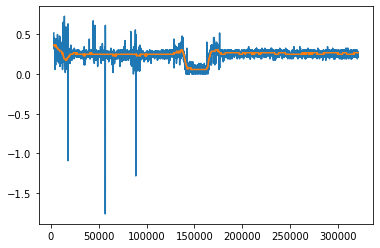

In [9]:
plot_img(y_axis, [0, 8000])
y_axisMedian = calculateMedian(y_axis, 100)
plot_img(y_axisMedian, [0, 8000])

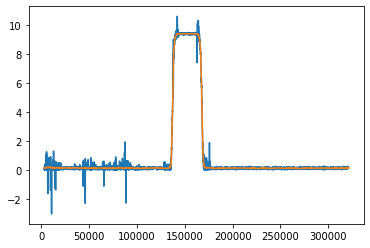

In [10]:
plot_img(z_axis, [0, 8000])
z_axisMedian = calculateMedian(z_axis, 100)
plot_img(z_axisMedian, [0, 8000])

------------------------------------------------------------------------------

In [11]:
# https://nbviewer.org/github/demotu/BMC/blob/master/notebooks/DetectCUSUM.ipynb

def CUSUM_alarms(x, drift, threshold):

    s = list([0])
    gMax = list([0])
    gMin = list([0])
    alarms = list()

    for t in range(1, len(x)):
        s_t = x[t] - x[t-1]
        gMax_t = max(gMax[t-1] + s_t - drift, 0)
        gMin_t = max(gMin[t-1] - s_t - drift, 0)

        if(gMax_t > threshold or gMin_t > threshold):
            alarms.append(t)
            #gMax_t = 0
            #gMin_t = 0

        s.append(s_t)
        gMax.append(gMax_t)
        gMin.append(gMax_t)

    return alarms

def plot_alarms(variable, alarms, show_range):
    plt.plot(range(show_range[1]-show_range[0]), variable[show_range[0]:show_range[1]])
    for xc in alarms:
        if xc < show_range[1]:
            plt.axvline(x=xc-show_range[0], color='red', linestyle='-')
    plt.plot(range(show_range[1]-show_range[0]), variable[show_range[0]:show_range[1]], color="blue")
    plt.show

In [12]:
# Alarms for Z-axis
drift = 0.07
threshold = 0.03
alarms_z_axis = CUSUM_alarms(z_axisMedian[0:8000], drift, threshold)
len(alarms_z_axis)

148

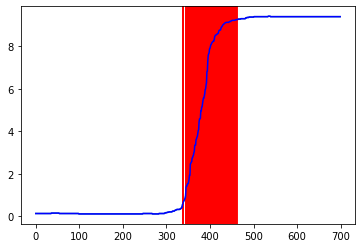

In [13]:
plot_alarms(z_axisMedian, alarms_z_axis, [3000, 3700])

In [14]:
# Alarms for X-axis
drift = 0.07
threshold = 0.03
alarms_x_axis = CUSUM_alarms(x_axisMedian[0:8000], drift, threshold)
len(alarms_x_axis)

157

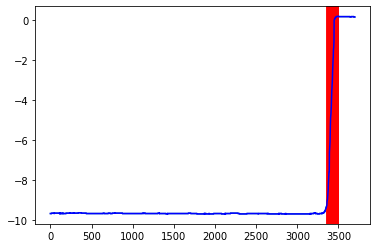

In [15]:
plot_alarms(x_axisMedian, alarms_x_axis, [0, 3700])

In [16]:
# Alarms for Z-axis
drift = 0.011
threshold = 0.005
alarms_y_axis = CUSUM_alarms(y_axisMedian[0:8000], drift, threshold)
len(alarms_y_axis)

174

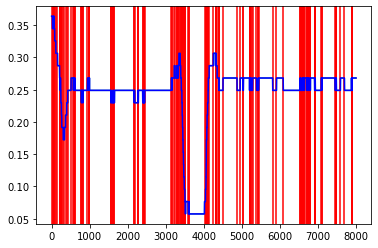

In [17]:
plot_alarms(y_axisMedian, alarms_y_axis, [0, 8000])

In [18]:
# Alarms for Z-axis
drift = 0.000001
threshold = 0.001
alarms_pressure = CUSUM_alarms(pressureMedian[0:8000], drift, threshold)
len(alarms_pressure)

364

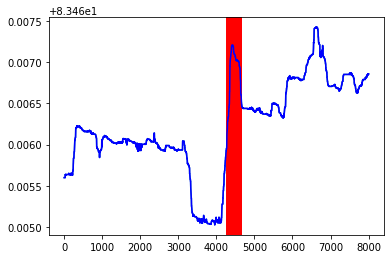

In [19]:
plot_alarms(pressureMedian, alarms_pressure, [0, 8000])

In [20]:
# https://scientya.com/bayesian-online-change-point-detection-an-intuitive-understanding-b2d2b9dc165b

### Trainset format

In [21]:
# series | timestamp | value | label

In [22]:
from datetime import datetime, timedelta

# Generate a Trainset compatible dataset
def TRAINSETcompatible(dataframe, variable):

    value = data[variable]
    originalTimestamps = data["Timestamp"]
    series = ['series_a'] * len(value)

    newTimestamp = list()
    t_0 = datetime.now() 
    for i in range(len(value)):
        t_i = str(t_0 + timedelta(seconds=int(originalTimestamps[i])))
        t_i = t_i.replace(" ", "T")
        t_i = t_i[:-6]
        t_i += "000Z" 
        newTimestamp.append(t_i)

    df = pd.DataFrame()
    df['series'] = series
    df["timestamp"] = newTimestamp
    df["value"] = value
    df["label"] = ""

    return df

df = TRAINSETcompatible(door1[0:100], "x")

NameError: name 'data' is not defined

In [ ]:
df.to_csv("test_trainable.csv", sep=",", index=False)